In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math
from time import time
import torch.distributions as tdis
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, RandomSampler, BatchSampler, DataLoader
sns.set_style('dark')

In [2]:
##Define FASTA reader and TXT reader
def read_from_file_with_enter(filename):
    fr = open(filename,'r')
    sample = ""
    samples = []
    for line in fr:
        if line.startswith('>'):
            sample = ""
            continue
        if line.startswith('\n'):
            samples.append(sample)
            continue
        sample += line[:-1]
    return samples

def ReadTxtName(rootdir):
    lines = []
    with open(rootdir, 'r') as file_to_read:
        while True:
            line = file_to_read.readline()
            if not line:
                break
            line = line.strip('\n')
            lines.append(line)
    return lines

In [3]:
##Z descriptions: 
z1 = 0
z2 = 0
z3 = 0
def Z(antigen):
    
    global z1
    global z2
    global z3
    
    if antigen == "A":
        z1     =  0.07
        z2     = -1.73
        z3     =  0.09
        
    if antigen == "V":
        z1     = -2.69
        z2     = -2.53
        z3     = -1.29
        
    if antigen == "L":
        z1     = -4.19
        z2     = -1.03
        z3     = -0.98
        
    if antigen == "I":
        z1     = -4.44
        z2     = -1.68
        z3     = -1.03 
        
    if antigen == "P":
        z1     = -1.22
        z2     =  0.88
        z3     =  2.23
        
    if antigen == "F":
        z1     = -4.92
        z2     =  1.30
        z3     =  0.45
        
    if antigen == "W":
        z1     = -4.75
        z2     =  3.65
        z3     =  0.85
    
    if antigen == "M":
        z1     = -2.49
        z2     = -0.27
        z3     = -0.41
    
    if antigen == "K":
        z1     =  2.84
        z2     =  1.41
        z3     = -3.14
        
    if antigen == "R":
        z1     =  2.88
        z2     =  2.52
        z3     = -3.44
        
    if antigen == "H":
        z1     =  2.41
        z2     =  1.74
        z3     =  1.11
        
    if antigen == "G":
        z1     =  2.23
        z2     = -5.36
        z3     =  0.30
        
    if antigen == "S":
        z1     =  1.96
        z2     = -1.63
        z3     =  0.57
        
    if antigen == "T":
        z1     =  0.92
        z2     = -2.09
        z3     = -1.40
        
    if antigen == "C":
        z1     =  0.71
        z2     = -0.97
        z3     =  4.13
        
    if antigen == "Y":
        z1     = -1.39
        z2     =  2.32
        z3     =  0.01
        
    if antigen == "N":
        z1     =  3.22
        z2     =  1.45
        z3     =  0.84
        
    if antigen == "Q":
        z1     =  2.18
        z2     =  0.53
        z3     = -1.14
        
    if antigen == "D":
        z1     =  3.64
        z2     =  1.13
        z3     =  2.36
        
    if antigen == "E":
        z1     =  3.08
        z2     =  0.39
        z3     = -0.07
        
    return z1, z2, z3

##ACC Transformation: transfer the dataset to the same length
def ACC (dataset):    

    ACCN = [0] * len(dataset)
    for i in range (len(ACCN)):
        ACCN[i] = [0] * 46 ## 45 variables for ACC and 1 for whether it's BPAs

    for i in range (len(dataset)):
        description = [0] * len(dataset[i])
        for k in range(len(dataset[i])):
            description[k] = Z(dataset[i][k])


        ##l=1
        ##Calculate AJJ:
        l   = 1
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][0] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][1] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][2] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][3] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][4] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][5] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][6] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][7] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][8] = cal

        ##l=2
        ##Calculate AJJ:
        l   = 2
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][9] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][10] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][11] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][12] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][13] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][14] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][15] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][16] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][17] = cal

        ##l=3
        ##Calculate AJJ:
        l   = 3
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][18] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][19] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][20] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][21] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][22] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][23] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][24] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][25] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][26] = cal

        ##l=4
        ##Calculate AJJ:
        l   = 4
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][27] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][28] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][29] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][30] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][31] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][32] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][33] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][34] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][35] = cal

        ##l=5
        ##Calculate AJJ:
        l   = 5
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][36] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][37] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][38] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][39] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][40] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][41] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][42] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][43] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][44] = cal
        
    return ACCN     

In [4]:
##Prepare T-cell Epitope dataset:

##Read the dataset
file    = r'./PT.txt'
datasetT1 = read_from_file_with_enter(file)
print(len(datasetT1))

file    = r'./NT.txt'
dataset21 = ReadTxtName(file)

datasetT2 = [0] * 774
for i in range (774):
    datasetT2[i] = dataset21[(i+1)*2-1]

print(len(datasetT2))

##Prepare B-cell Epitope dataset:
##Read the dataset
file      = r'./positiveset_10AA'
datasetB1 = ReadTxtName(file)

file      = r'./negativeset_10AA'
datasetB2 = ReadTxtName(file)

print(len(datasetB1))
print(len(datasetB2))

984
774
4925
4925


In [5]:
file      = r'./PA.txt'
datasetA  = ReadTxtName(file)
print(len(datasetA))

target = ACC(datasetA)
for i in range (len(target)):
    if i < 100:
        target[i][45] = 1
    if i > 99:
        target[i][45] = 0
print(len(target))

200
200


In [6]:
def get_model(in_size):
    return nn.Sequential(
            nn.Linear(in_size, 90),
            nn.Tanh(),
            nn.Linear(90, 60),
            nn.Tanh(),
            nn.Linear(60, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.ReLU()
        )

def Antigens(antigens, num_epochs=9000, batch_size=128, model=None, lrate=0.001):
    
    counter   = antigens.shape[1] - 1
    X         = antigens[:,:counter]        #Protein ACC
    Y         = antigens[:,45:]             #Whether it's BPA
    
    
    if not model:
        model = get_model(X.shape[1])
        
    opt   = optim.Adam(model.parameters(), lr=lrate)
    td    = TensorDataset(X, Y)
    epoch = 0

    while epoch < num_epochs: 
        for x, y in DataLoader(td, batch_size, shuffle=True, drop_last=True):   
            opt.zero_grad()
            result = model(x)
            loss   = ((result - y)**2).mean()
            #loss   = nn.CrossEntropyLoss(result, y).mean()
            #loss   = torch.mean(torch.clamp(1 - result.t() * y, min=0))  # hinge loss
            #loss  += 0.01 * torch.mean(model.weight ** 2)  # l2 penalty
            loss.backward()
            opt.step()
    
        epoch += 1
        
        print(loss)
    return model

In [7]:
Amodel = Antigens(torch.tensor(target))

tensor(0.5154, grad_fn=<MeanBackward0>)
tensor(0.4917, grad_fn=<MeanBackward0>)
tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.4503, grad_fn=<MeanBackward0>)
tensor(0.4237, grad_fn=<MeanBackward0>)
tensor(0.4678, grad_fn=<MeanBackward0>)
tensor(0.3916, grad_fn=<MeanBackward0>)
tensor(0.4245, grad_fn=<MeanBackward0>)
tensor(0.3940, grad_fn=<MeanBackward0>)
tensor(0.3999, grad_fn=<MeanBackward0>)
tensor(0.3726, grad_fn=<MeanBackward0>)
tensor(0.3987, grad_fn=<MeanBackward0>)
tensor(0.3901, grad_fn=<MeanBackward0>)
tensor(0.3340, grad_fn=<MeanBackward0>)
tensor(0.3540, grad_fn=<MeanBackward0>)
tensor(0.3327, grad_fn=<MeanBackward0>)
tensor(0.3439, grad_fn=<MeanBackward0>)
tensor(0.3360, grad_fn=<MeanBackward0>)
tensor(0.3120, grad_fn=<MeanBackward0>)
tensor(0.3083, grad_fn=<MeanBackward0>)
tensor(0.3001, grad_fn=<MeanBackward0>)
tensor(0.3041, grad_fn=<MeanBackward0>)
tensor(0.2840, grad_fn=<MeanBackward0>)
tensor(0.2689, grad_fn=<MeanBackward0>)
tensor(0.2948, grad_fn=<MeanBackward0>)


tensor(0.1326, grad_fn=<MeanBackward0>)
tensor(0.1266, grad_fn=<MeanBackward0>)
tensor(0.1432, grad_fn=<MeanBackward0>)
tensor(0.1223, grad_fn=<MeanBackward0>)
tensor(0.1508, grad_fn=<MeanBackward0>)
tensor(0.1268, grad_fn=<MeanBackward0>)
tensor(0.1311, grad_fn=<MeanBackward0>)
tensor(0.1378, grad_fn=<MeanBackward0>)
tensor(0.1449, grad_fn=<MeanBackward0>)
tensor(0.1252, grad_fn=<MeanBackward0>)
tensor(0.1245, grad_fn=<MeanBackward0>)
tensor(0.1298, grad_fn=<MeanBackward0>)
tensor(0.1126, grad_fn=<MeanBackward0>)
tensor(0.1318, grad_fn=<MeanBackward0>)
tensor(0.1324, grad_fn=<MeanBackward0>)
tensor(0.1362, grad_fn=<MeanBackward0>)
tensor(0.1373, grad_fn=<MeanBackward0>)
tensor(0.1353, grad_fn=<MeanBackward0>)
tensor(0.1228, grad_fn=<MeanBackward0>)
tensor(0.1168, grad_fn=<MeanBackward0>)
tensor(0.1266, grad_fn=<MeanBackward0>)
tensor(0.1292, grad_fn=<MeanBackward0>)
tensor(0.1197, grad_fn=<MeanBackward0>)
tensor(0.1223, grad_fn=<MeanBackward0>)
tensor(0.1274, grad_fn=<MeanBackward0>)


tensor(0.0560, grad_fn=<MeanBackward0>)
tensor(0.0506, grad_fn=<MeanBackward0>)
tensor(0.0486, grad_fn=<MeanBackward0>)
tensor(0.0496, grad_fn=<MeanBackward0>)
tensor(0.0639, grad_fn=<MeanBackward0>)
tensor(0.0514, grad_fn=<MeanBackward0>)
tensor(0.0569, grad_fn=<MeanBackward0>)
tensor(0.0538, grad_fn=<MeanBackward0>)
tensor(0.0529, grad_fn=<MeanBackward0>)
tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0718, grad_fn=<MeanBackward0>)
tensor(0.0545, grad_fn=<MeanBackward0>)
tensor(0.0567, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(0.0682, grad_fn=<MeanBackward0>)
tensor(0.0542, grad_fn=<MeanBackward0>)
tensor(0.0438, grad_fn=<MeanBackward0>)
tensor(0.0635, grad_fn=<MeanBackward0>)
tensor(0.0550, grad_fn=<MeanBackward0>)
tensor(0.0564, grad_fn=<MeanBackward0>)
tensor(0.0558, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0520, grad_fn=<MeanBackward0>)
tensor(0.0567, grad_fn=<MeanBackward0>)
tensor(0.0564, grad_fn=<MeanBackward0>)


tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0238, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)


tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)


tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)


tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)


tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)


tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)


tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)


tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)


tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(7.8781e-05, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward

tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(4.9118e-05, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward

tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(9.3153e-05, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward

tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)


tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)


tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)


tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)


tensor(4.0745e-05, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward

tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(8.5552e-05, grad_fn=<MeanBackward

tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(8.3861e-05, grad_fn=<MeanBackward

tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)


tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)


tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(4.8670e-05, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward

tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


In [8]:
candidates = []
for i in range (len(datasetB1)):
    for j in range (len(datasetT1)):
        candidates.append(datasetB1[i]+datasetT1[j])
        candidates.append(datasetT1[j]+datasetB1[i])
print(len(candidates))

9692400


In [9]:
dataset = []

for i in range (len(candidates)):
    target  = ACC([candidates[i]])[0][0:45]
    if (Amodel(torch.tensor(target)) - 1)**2<0.015:
        dataset.append(candidates[i])
print(len(dataset))

697566


In [10]:
Ndataset1 = []
Ndataset  = []
for i in range(len(datasetT2)):
    for j in range (len(datasetB2)):
        Ndataset1.append(datasetB2[j]+datasetT2[i])
for i in range (len(dataset)):
    Ndataset.append(Ndataset1[i*5])
print(len(Ndataset))

697566


In [11]:
finalset = dataset + Ndataset

file = open('trainset.txt','w')
A    = '\n'
file.write(A.join(finalset))

f    = r'./trainset.txt'
data = ReadTxtName(f)
print(len(data))

1395132


In [22]:
target = ACC(finalset)
for i in range (len(target)):
    if i < 667786:
        target[i][45]=1
    if i > 667786:
        target[i][45]=0

print(len(target))

1395132


In [13]:
net = torch.load('V2model.pkl')

In [14]:
Vmodel = Antigens(torch.tensor(target), num_epochs=300, batch_size=8192, model=net, lrate=0.001)

tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(0.0489, grad_fn=<MeanBackward0>)
tensor(0.0467, grad_fn=<MeanBackward0>)
tensor(0.0426, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)
tensor(0.0425, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0357, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0361, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)


tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0240, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)


In [15]:
torch.save(Vmodel, 'quickmodel.pkl')

In [24]:
##Test dataset with training dataset

target1 = target[0:697566]
target2 = target[697566:1395132]

train_test1 = [0] * 100
for i in range(len(train_test1)):
    train_test1[i] = target1[i*5000][0:45]
    
train_test2 = [0] * 100
for i in range(len(train_test2)):
    train_test2[i] = target2[i*5000][0:45] 

train_test = train_test1 + train_test2
print(len(train_test))

200


In [25]:
##Test dataset with new dataset
file      = r'./positiveset_12AA'
datasetB1 = ReadTxtName(file)

file      = r'./negativeset_12AA'
datasetB2 = ReadTxtName(file)

print(len(datasetB1))
print(len(datasetB2))

candidates = []
for i in range (len(datasetB1)):
    for j in range (len(datasetT1)):
        candidates.append(datasetB1[i]+datasetT1[j])
        candidates.append(datasetT1[j]+datasetB1[i])
print(len(candidates))

dataset = []

for i in range (len(candidates)):
    target  = ACC([candidates[i]])[0][0:45]
    if (Amodel(torch.tensor(target)) - 1)**2<0.015:
        dataset.append(target)
    if len(dataset) > 99:
        break
        
print(len(dataset))

Ndataset1 = []
Ndataset  = []
for i in range(len(datasetT2)):
    for j in range (len(datasetB2)):
        Ndataset1.append(datasetB2[j]+datasetT2[i])
for i in range (len(dataset)):
    Ndataset.append(ACC([Ndataset1[i*25000]])[0][0:45])              
    if len(Ndataset) > 99:
        break
print(len(Ndataset))

test_set = dataset + Ndataset

4925
4925
9692400
100
100


In [26]:
def PR(test, model = Vmodel, SH = 0.01):
    P      = 0
    F      = 0    
    countP = 0
    countF = 0
    
    for i in range (len(test)):
        if (model(torch.tensor(test[i]))-1)**2 < SH:
            countP += 1
            if i < 100:
                P += 1
            if i > 99:
                F += 1
        else:
            if i > 99:
                countF += 1
                
    TPR      = P / 100    
    FPR      = F / 100
    accuracy = (P + countF) / 200
    
    return TPR, FPR, accuracy
    

In [41]:
PR(train_test, SH = 1)

(1.0, 0.04, 0.98)

In [44]:
PR(test_set, SH = 10)

(1.0, 1.0, 0.5)

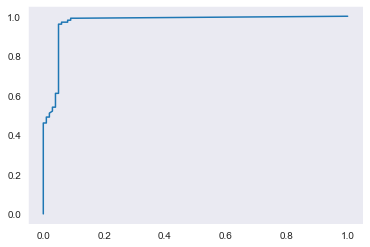

In [82]:
##Test with training dataset
TPR = []
FPR = []
accuracy = []
for i in range (1002):
    a, b, c = PR(test_set, SH=i*0.001)
    TPR.append(a)
    FPR.append(b)
    accuracy.append(c)
    
plt.plot(FPR,TPR)



In [78]:
from sklearn.metrics import roc_curve, auc

roc_auc = auc(FPR,TPR)
print(roc_auc)

0.9999


In [79]:
import csv
import pandas as pd
TPRset = pd.DataFrame(data=TPR)
TPRset.to_csv('TPR.csv',encoding='gbk')

In [80]:
FPRset = pd.DataFrame(data=FPR)
FPRset.to_csv('FPR.csv',encoding='gbk')

In [81]:
accset = pd.DataFrame(data=accuracy)
accset.to_csv('accuracy.csv',encoding='gbk')

In [69]:
file      = r'./SProtein.txt'
Sprotein  = ReadTxtName(file)

In [85]:
protein  = Sprotein[0]

B_lenth  = 30
B_num    = len(protein) - B_lenth + 1
Bpeptide = [0] * B_num
for i in range (B_num):
    Bpeptide[i] = protein[i:i+B_lenth]
    
results = []

for i in range (B_num):
    target = ACC([Bpeptide[i]]) 
    if (Vmodel(torch.tensor(target[0][0:45]))-1)**2<0.00025:
        results.append(Bpeptide[i])
        print(Bpeptide[i])
        print(i+1, '--', i+1+29)


print(len(results))

VLLPLVSSQCVNLTTRTQLPPAYTNSFTRG
6 -- 35
PLVSSQCVNLTTRTQLPPAYTNSFTRGVYY
9 -- 38
NLTTRTQLPPAYTNSFTRGVYYPDKVFRSS
17 -- 46
QLPPAYTNSFTRGVYYPDKVFRSSVLHSTQ
23 -- 52
PAYTNSFTRGVYYPDKVFRSSVLHSTQDLF
26 -- 55
FTRGVYYPDKVFRSSVLHSTQDLFLPFFSN
32 -- 61
RGVYYPDKVFRSSVLHSTQDLFLPFFSNVT
34 -- 63
YPDKVFRSSVLHSTQDLFLPFFSNVTWFHA
38 -- 67
TQDLFLPFFSNVTWFHAIHVSGTNGTKRFD
51 -- 80
VYFASTEKSNIIRGWIFGTTLDSKTQSLLI
90 -- 119
WIFGTTLDSKTQSLLIVNNATNVVIKVCEF
104 -- 133
GTTLDSKTQSLLIVNNATNVVIKVCEFQFC
107 -- 136
TTLDSKTQSLLIVNNATNVVIKVCEFQFCN
108 -- 137
DSKTQSLLIVNNATNVVIKVCEFQFCNDPF
111 -- 140
IKVCEFQFCNDPFLGVYYHKNNKSWMESEF
128 -- 157
KVCEFQFCNDPFLGVYYHKNNKSWMESEFR
129 -- 158
VCEFQFCNDPFLGVYYHKNNKSWMESEFRV
130 -- 159
EFQFCNDPFLGVYYHKNNKSWMESEFRVYS
132 -- 161
DPFLGVYYHKNNKSWMESEFRVYSSANNCT
138 -- 167
LGVYYHKNNKSWMESEFRVYSSANNCTFEY
141 -- 170
MESEFRVYSSANNCTFEYVSQPFLMDLEGK
153 -- 182
YSSANNCTFEYVSQPFLMDLEGKQGNFKNL
160 -- 189
SSANNCTFEYVSQPFLMDLEGKQGNFKNLR
161 -- 190
SANNCTFEYVSQPFLMDLEGKQGNFKNLRE
162 -- 191
KNLREFVFKNIDG

In [92]:
count = 0
for i in range (len(results)):
    if ((Amodel(torch.tensor(ACC([results[i]])[0][0:45])))-1)**2<0.4:
        count+=1
print(count)

92
